<a href="https://colab.research.google.com/github/k-ganda/air_quality_forcasting_ML/blob/main/notebook/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets

train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
# Check for missing values
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [8]:
# Interpolation of pm2.5
train['pm2.5'] = train['pm2.5'].interpolate(method='linear')


In [9]:
# Confirm if all null are handled
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
pm2.5      24
dtype: int64


In [10]:
# Fill NaN values with 0
train['pm2.5'] = train['pm2.5'].fillna(0)

In [11]:
# Confirm if all null are handled
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [12]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [13]:
# Scaling the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [14]:
# Time windowing

def create_windows(data, window_size, step_size):
    windows = []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size]
        windows.append(window)
    return np.array(windows)

window_size = 24
step_size = 1
X_train_windows = create_windows(X_train_scaled, window_size, step_size)

In [15]:
# Creating Input-output sequences
y_train_windows = y_train[window_size - 1:].values

print(X_train_windows.shape)
print(y_train_windows.shape)

(30653, 24, 9)
(30653,)


In [16]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_lstm = X_train_windows.reshape((X_train_windows.shape[0],
                                        X_train_windows.shape[1],
                                        X_train_scaled.shape[1]))

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [20]:
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop, SGD

# define model
model = Sequential([
    LSTM(32, activation='tanh', input_shape=(window_size, X_train.shape[1]),
         return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(16, activation='tanh', kernel_regularizer=l2(0.01)),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 24, 32)              │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,529 (33.32 KB)

 Trainable params: 8,529 (33.32 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_windows,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - lambda: 122.8145 - loss: 15571.6777 - val_lambda: 110.5814 - val_loss: 20042.4941
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 114.6085 - loss: 13673.1963 - val_lambda: 102.8763 - val_loss: 17962.6875
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - lambda: 105.7556 - loss: 11738.9707 - val_lambda: 96.9607 - val_loss: 16280.2109
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - lambda: 99.1465 - loss: 10307.2012 - val_lambda: 92.5182 - val_loss: 14928.4697
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 94.6415 - loss: 9180.5459 - val_lambda: 87.4560 - val_loss: 13565.0703
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 94.6926 - loss: 8218.4639 - val_lambda: 84.4439 - val_loss: 12319.0332
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - lambda: 94.7599 - loss: 7596.4570 - val_lambda: 82.5343 - val_loss: 11334.2441
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 24

958/958 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


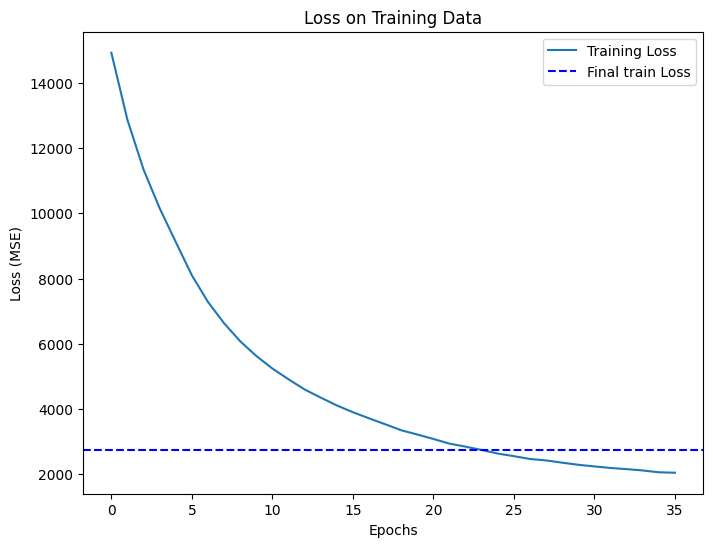

Final Training Loss (MSE): 2731.1980037740805


In [22]:
# Calculate training loss
train_predictions = model.predict(X_train_lstm)
train_loss = np.mean((y_train_windows - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [23]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)

# Pad the test data to get predictions for all rows
padding_size = window_size - 1  # Number of data points to pad
padded_X_test_scaled = np.pad(X_test_scaled, ((padding_size, 0), (0, 0)), mode='reflect')

X_test_windows = create_windows(padded_X_test_scaled, window_size, step_size)
X_test_lstm = X_test_windows.reshape((X_test_windows.shape[0], X_test_windows.shape[1], X_test_scaled.shape[1]))

# Make predictions
predictions = model.predict(X_test_lstm)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Remove the predictions corresponding to the padded data to match the original test set size
predictions = predictions[-len(test):]

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID'
submission = submission.sort_values(by='row ID')

# Save the submission file
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
